## Structure Function (Error Bar) Metric on DDF

**Author(s):** Weixiang Yu & Gordon Richards
<br>**Last updated:** 03/19/2021
<br>**Short description:** See [this notebook](./00_SFErrorMetric.ipynb) from more information about this metric.

### 0. Software Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import glob
import os, sys

In [2]:
# automatically extract username
your_username = os.getcwd().split('/')[5]
print(f'Your automatically extracted username is: {your_username}.'
        '\nIf it is incorrect, please mannually reset it.')

Your automatically extracted username is: ywx649999311.
If it is incorrect, please mannually reset it.


##### Import the sims_maf modules needed.

In [3]:
# add the path the scripts
sys.path.insert(0, '../scripts/')

In [4]:
# import lsst.sim.maf moduels modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
from lsst.sims.maf.stackers import BaseStacker
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

# import convenience functions
from opsimUtils import *

# import custom stacker/metrics from script
from AGNStacker import MagErrStacker
from AGNMetrics import SFErrorMetric

### 1. Run on one OpSim

In [5]:
# run_name2 = 'descddf_v1.5_10yrs'
# opsdb2 = db.OpsimDatabase(f'/home/idies/workspace/lsst_cadence/FBS_1.5/{run_name2}.db')

In [6]:
#Read in an opSim (in this case "baseline_v1.4_10yrs.db")
run_name = 'agnddf_v1.5_10yrs'
opsdb1 = db.OpsimDatabase(f'/home/idies/workspace/lsst_cadence/FBS_1.5/{run_name}.db')
outDir = '/home/idies/workspace/Temporary/{}/scratch/MAFOutput/tmp/SF/DDF/031921/'.format(your_username)
resultsDb = db.ResultsDb(outDir=outDir)

In [7]:
ddfFields = ['COSMOS', 'XMM-LSS', 'ELAISS1', 'ECDFS', 'EDFS']

In [8]:
# params for the metric
src_mag = 24
band = 'u'
my_bins = np.logspace(-2, np.log10(3650), 21)
my_weights = np.full(20, 1/20)

# slicer and constraint
slicer = slicers.HealpixSlicer(nside=64)
base_constraint = f'filter = "{band}"'

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [9]:
run = opsdb1
bundleDict = {}

# loop through each DDF Field & declare metric bundle
for ddf in ddfFields[-2:]:
    proposalIds = ddfInfo(run, ddf)['proposalId']
    
    # ddf constraint based on number of fields in opsim
    if len(proposalIds) > 1:
        ddf_constraint = base_constraint.format(band) + \
                        f" and (proposalId = {proposalIds[0]} or proposalId = {proposalIds[1]})"
    else:
        ddf_constraint = base_constraint.format(band) + \
                        f" and proposalId = {proposalIds[0]}"
    
    # create metric and update name with DDF field name
    metric = SFErrorMetric(src_mag, band, bins=my_bins, weight=my_weights)
    metric.name = metric.metricName + f'_{ddf}'
    
    # make into a bundle
    mb = metricBundles.MetricBundle(metric, slicer, ddf_constraint, \
                                    stackerList=[MagErrStacker(src_mag)])
    # add it to bundle dict
    bundleDict[metric.name] = mb

In [10]:
group = metricBundles.MetricBundleGroup(bundleDict, run, outDir=outDir, resultsDb=resultsDb)
group.runAll()

Querying database SummaryAllProps with constraint filter = "u" and (proposalId = 2 or proposalId = 4) for columns ['fieldRA', 'visitExposureTime', 'observationStartMJD', 'filter', 'fieldDec', 'fiveSigmaDepth']
Found 3616 visits
Running:  ['SFError_24_u_EDFS']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "u" and proposalId = 6 for columns ['fieldRA', 'visitExposureTime', 'observationStartMJD', 'filter', 'fieldDec', 'fiveSigmaDepth']
Found 4052 visits
Running:  ['SFError_24_u_ECDFS']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


#### Make DDF High-Res Plots

83.85417312845595 96.14582687154403 -6.145826871544031 6.145826871544031
The interval between parallels is 1 deg 0.00'.
The interval between meridians is 1 deg 0.00'.
83.85417312845595 96.14582687154403 -6.145826871544031 6.145826871544031
The interval between parallels is 1 deg 0.00'.
The interval between meridians is 1 deg 0.00'.


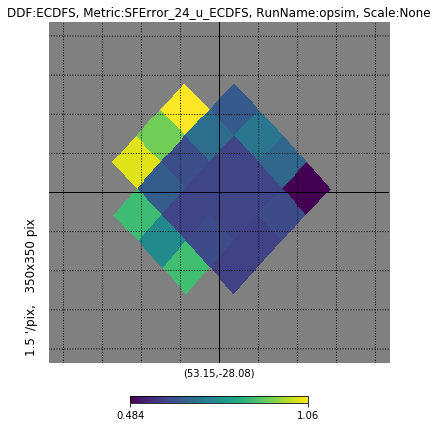

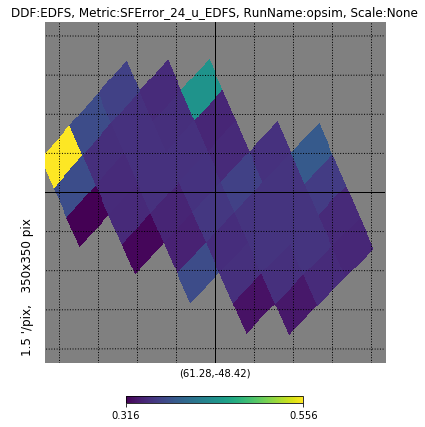

In [11]:
for mb in bundleDict:
    ddf = mb.split('_')[-1]
    plotSky_DDF(bundleDict[mb], ddf, xsize=350)

### 2. Run on 20 opsims and compare summary statistics

In [12]:
# import dask and create client
from dask.distributed import Client
client = Client(n_workers=16)

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [13]:
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

dbDir = '/home/idies/workspace/lsst_cadence/FBS_1.5/'
outDir = f'/home/idies/workspace/Temporary/{your_username}/LSST_MAF/wy/Var/SF/DDF_031921/ResultDBs/'
metricDataPath = f'/home/idies/workspace/Temporary/{your_username}/LSST_MAF/wy/Var/SF/DDF_031921/MetricData/'

if not os.path.exists(os.path.abspath(outDir)):
    os.makedirs(os.path.abspath(outDir))
    
if not os.path.exists(os.path.abspath(metricDataPath)):
    os.makedirs(os.path.abspath(metricDataPath))

In [14]:
dbRuns = show_opsims(dbDir)
dbFamil = [run.split('_')[0] for run in dbRuns]
dfRuns = pd.DataFrame({'run':dbRuns, \
                       'runFamil':dbFamil}).sort_values(by='runFamil').reset_index(drop=True)
dfRunPick = dfRuns.drop_duplicates(subset=['runFamil']).reset_index(drop=True)

In [15]:
# define function to run MAF on one opsim which is easily parallelziable. 
def run_sf_ddf(run, src_mags, dbDir, outDir, metricDataPath, **kwargs):
    """
    Function to run SFErrorMetric on one OpSim. 
    
    Args:
        run (str): The OpSim cadence run name.
        src_mags (list): At what source magnitudes to evaluate, keys are bands. 
            Defaults to {'u': [24.15], 'g': [24]}
        dbDir (str): The path to the OpSim databases.
        outDir (str): The path to the resultdb databases.
        metricDataPath (str): The path to the actual metric data (.npz files). 
    """
    
    # init connection given run name
    opSimDb, resultDb = connect_dbs(dbDir, outDir, dbRuns=[run])
    
    # if no DDF return
    if len(opSimDb[run].fetchPropInfo()[1]['DD']) == 0:
        return
    
    # init bundleDict
    bundleDict = {}
                    
    # shared configs
    slicer = slicers.HealpixSlicer(nside=64)
    base_constraint = 'filter = "{}"'
    summaryMetrics = [metrics.MedianMetric(), metrics.MeanMetric(), metrics.RmsMetric()]
    
    # loop through bands and source mags to init metricBundle
    for band in src_mags:
        mags = src_mags[band]
        
        for mag in mags:
            
            # loop through each DDF
            for ddf in ddfFields:                
                proposalIds = ddfInfo(opSimDb[run], ddf)['proposalId']
                
                # ddf constraint based on number of fields in opsim
                if len(proposalIds) > 1:
                    ddf_constraint = base_constraint.format(band) + \
                                    f" and (proposalId = {proposalIds[0]} or proposalId = {proposalIds[1]})"
                else:
                    ddf_constraint = base_constraint.format(band) + \
                                    f" and proposalId = {proposalIds[0]}"
                                    
                sf_metric = SFErrorMetric(mag, band, **kwargs)
                sf_metric.name = sf_metric.metricName + f'_{ddf}'
                mb = metricBundles.MetricBundle(sf_metric, slicer, ddf_constraint, 
                                                stackerList=[MagErrStacker(mag)])
                
                bundleDict[sf_metric.name] = mb
    
    # set runname and summary stat
    for key in bundleDict:
        bundleDict[key].setRunName(run)
        bundleDict[key].setSummaryMetrics(summaryMetrics)

    # make a group
    metricGroup = metricBundles.MetricBundleGroup(bundleDict, opSimDb[run], metricDataPath, 
                                                  resultDb[run], verbose=False)
    metricGroup.runAll()
    
    # close dbs
    opSimDb[run].close()
    resultDb[run].close()
#     return metricGroup

In [15]:
# mbg = run_sf_ddf(dfRunPick.run.values[0], src_mags, dbDir, outDir, metricDataPath)
# mbg.bundleDict['SFError_24_g_EDFS'].runName

In [16]:
# run on 20 opsims
src_mags = {'u': [24.15], 'g': [24]}
my_bins = np.logspace(-2, np.log10(3650), 21)
my_weights = np.full(20, 1/20)

# %%time
rt = []

# loop over all opsims to evaluate and submite task to dask scheduler
for run in dfRunPick.run.values:
    r = client.submit(run_sf_ddf, run, src_mags, dbDir, outDir, metricDataPath, 
                      bins=my_bins, weight=my_weights)
    rt.append(r)
    
# collect result
result = client.gather(rt)

### 3. Load result from disk

In [17]:
# import metric evaluations
bundleDicts = {}
resultDbPath = outDir

resultDbsView = getResultsDbs(resultDbPath)
for runName in resultDbsView:
    bundleDicts[runName] = bundleDictFromDisk(resultDbsView[runName], runName, metricDataPath)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSID

In [18]:
# Check keys
dbRuns = list(resultDbsView.keys())
bd_keys = list(bundleDicts[dbRuns[1]].keys())
print(bd_keys)

[(1, 'SFError_24.15_u_EDFS'), (2, 'SFError_24.15_u_COSMOS'), (3, 'SFError_24_g_ELAISS1'), (4, 'SFError_24_g_COSMOS'), (5, 'SFError_24_g_ECDFS'), (6, 'SFError_24_g_XMM-LSS'), (7, 'SFError_24.15_u_ELAISS1'), (8, 'SFError_24.15_u_XMM-LSS'), (9, 'SFError_24_g_EDFS'), (10, 'SFError_24.15_u_ECDFS')]


### 4. View/Plot Summary Statistics (Mean, Median, RMS)
The bar plots showns are the median of 'SFError_24.15_u' for 5 DDFs

In [19]:
getSummary(resultDbsView, 'SFError_24.15_u_EDFS', 'Median', pandas=True)

,metricId,metricName,slicerName,metricMetadata,summaryName,summaryValue,runName
0,7,SFError_24.15_u_EDFS,HealpixSlicer,u and proposalId 2,Median,0.487050,roll_mod2_dust_sdf_0.20_v1.5_10yrs
1,1,SFError_24.15_u_EDFS,HealpixSlicer,u and proposalId 3,Median,0.493585,wfd_depth_scale0.90_v1.5_10yrs
2,10,SFError_24.15_u_EDFS,HealpixSlicer,u and proposalId 4,Median,0.474756,greedy_footprint_v1.5_10yrs
3,2,SFError_24.15_u_EDFS,HealpixSlicer,u and (proposalId 5 or proposalId 6),Median,0.446388,descddf_v1.5_10yrs
4,1,SFError_24.15_u_EDFS,HealpixSlicer,u and proposalId 3,Median,0.477038,dcr_nham1_ug_v1.5_10yrs
5,7,SFError_24.15_u_EDFS,HealpixSlicer,u and proposalId 2,Median,0.441772,spiders_v1.5_10yrs
6,8,SFError_24.15_u_EDFS,HealpixSlicer,u and proposalId 6,Median,0.472084,goodseeing_gri_v1.5_10yrs
7,10,SFError_24.15_u_EDFS,HealpixSlicer,u and proposalId 4,Median,0.484062,twilight_neo_mod2_v1.5_10yrs
8,2,SFError_24.15_u_EDFS,HealpixSlicer,u and proposalId 5,Median,0.473087,short_exp_2ns_5expt_v1.5_10yrs
9,3,SFError_24.15_u_EDFS,HealpixSlicer,u and (proposalId 7 or proposalId 10),Median,0.467149,daily_ddf_v1.5_10yrs


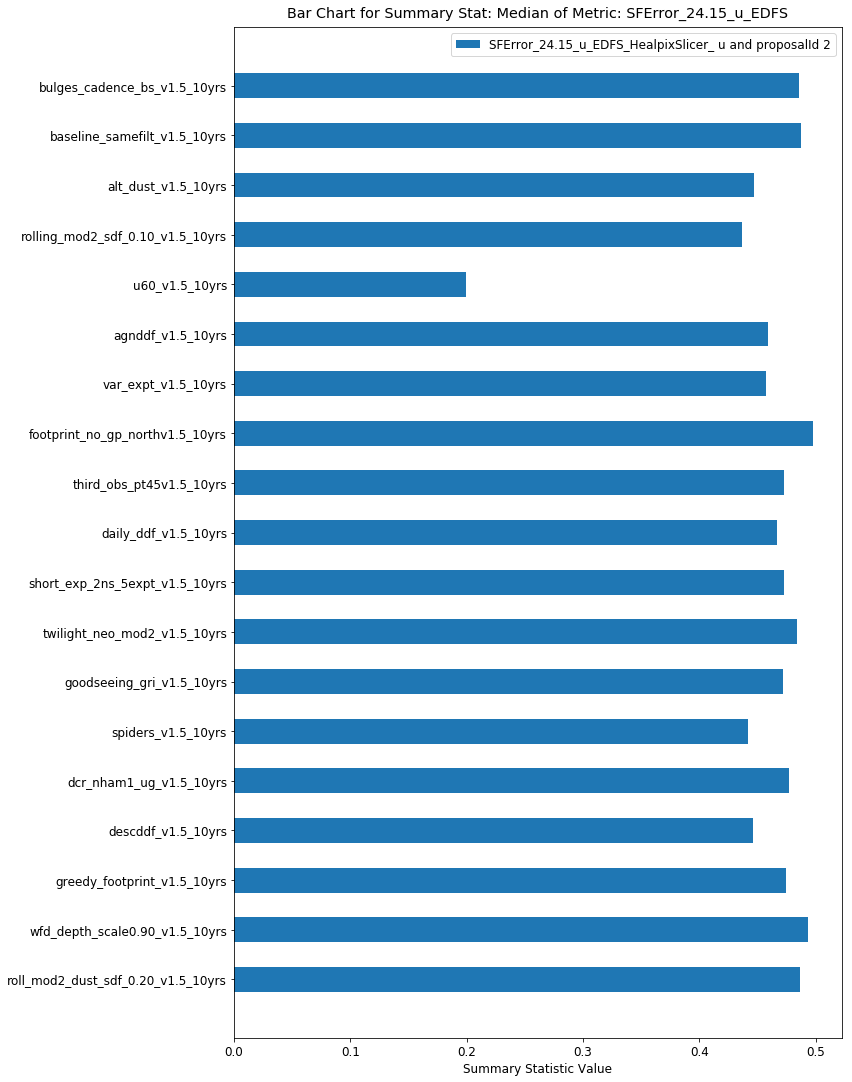

In [20]:
plotSummaryBarh(resultDbsView, 'SFError_24.15_u_EDFS', 'Median')

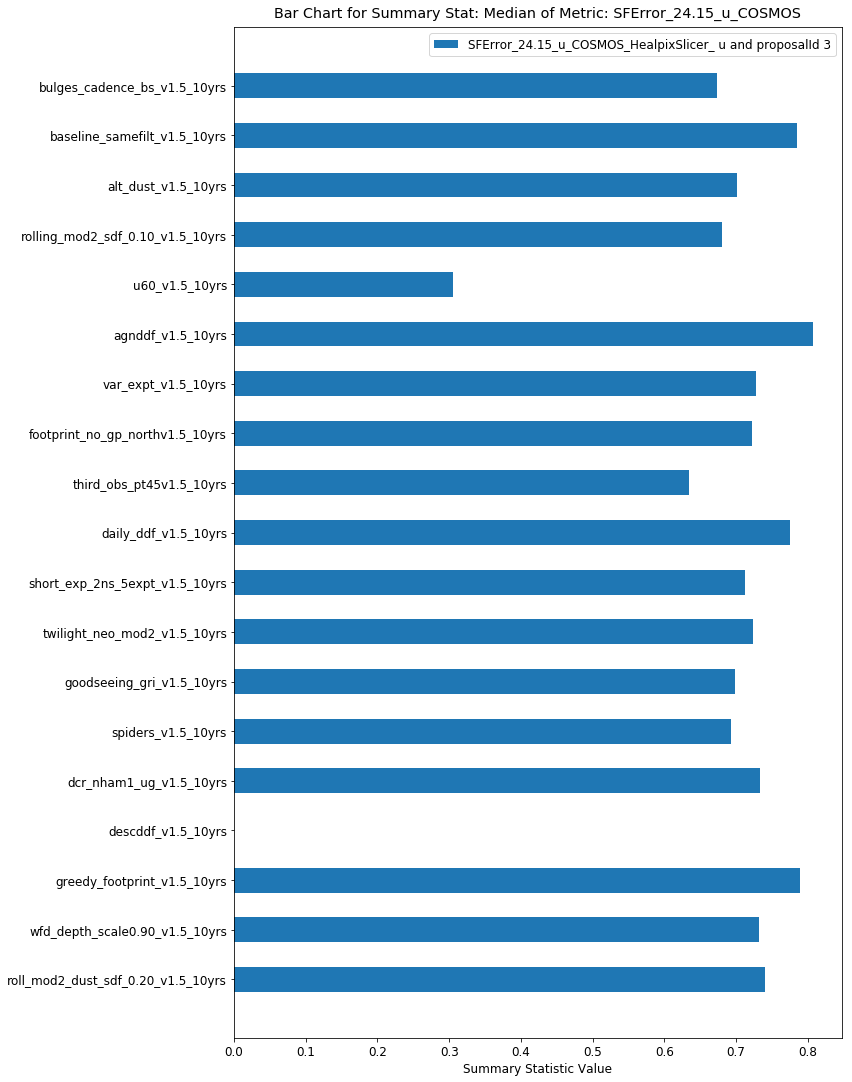

In [21]:
plotSummaryBarh(resultDbsView, 'SFError_24.15_u_COSMOS', 'Median')

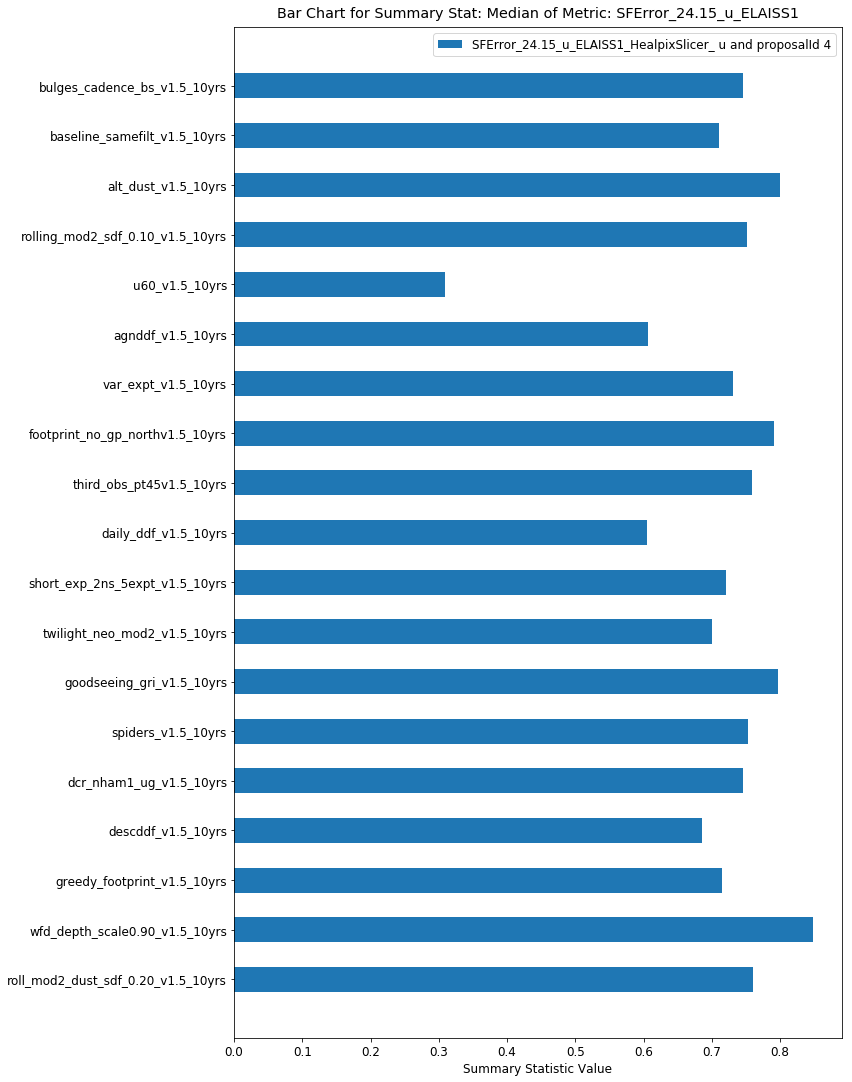

In [22]:
plotSummaryBarh(resultDbsView, 'SFError_24.15_u_ELAISS1', 'Median')

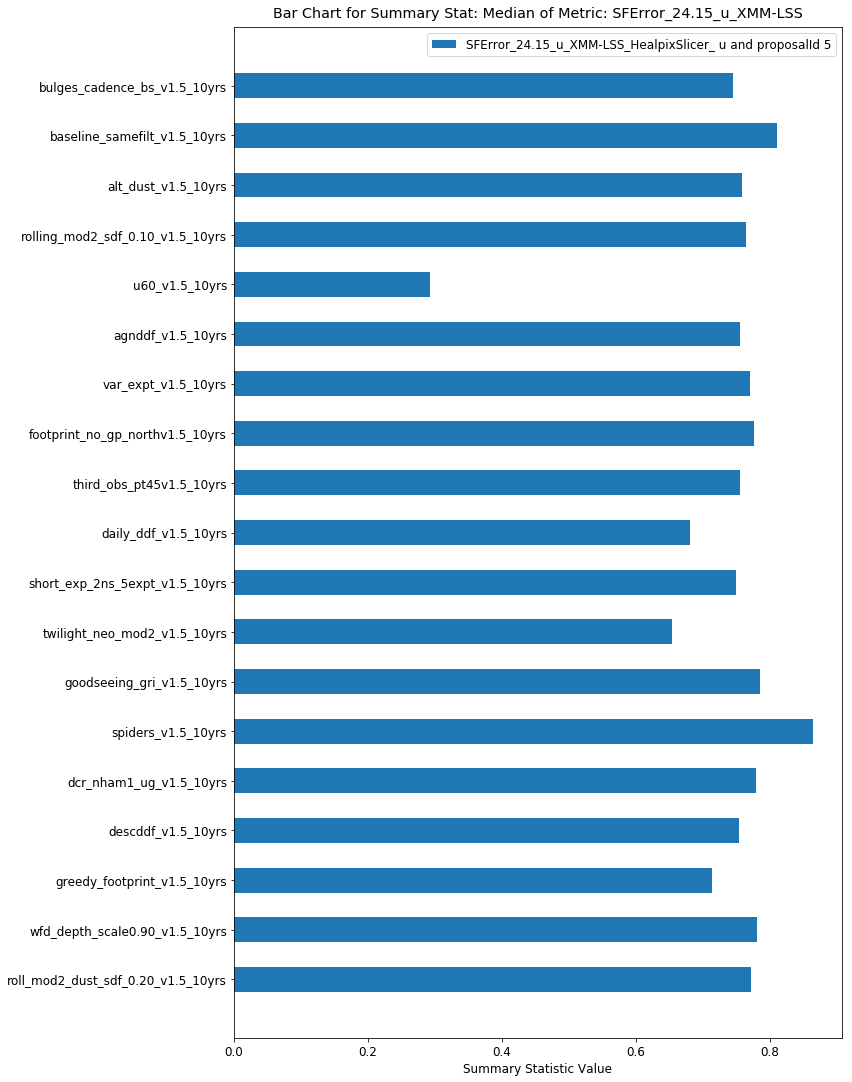

In [23]:
plotSummaryBarh(resultDbsView, 'SFError_24.15_u_XMM-LSS', 'Median')

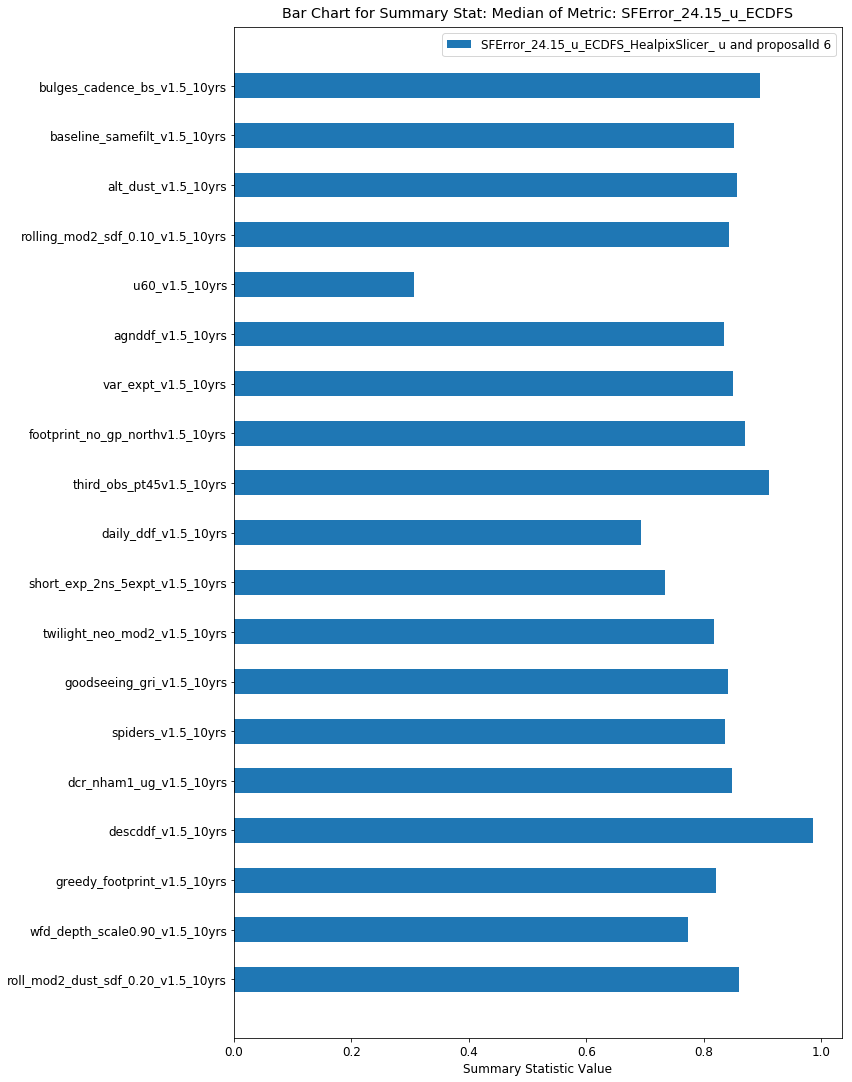

In [24]:
plotSummaryBarh(resultDbsView, 'SFError_24.15_u_ECDFS', 'Median')